In [1]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, SSMCMain.SpaceMMiCRM, MLSolver

Precompiling packages...
  10476.3 ms  ✓ SSMCMain
  1 dependency successfully precompiled in 13 seconds. 475 already precompiled.


In [69]:
using CairoMakie, ProgressLogging
using Base.Threads
using BenchmarkTools
using JLD2, Geppetto

# Steven's layer model

## Basic no space solve

- 4 strains with 7 resources
- I'll make first the "glucose" which is all leaked

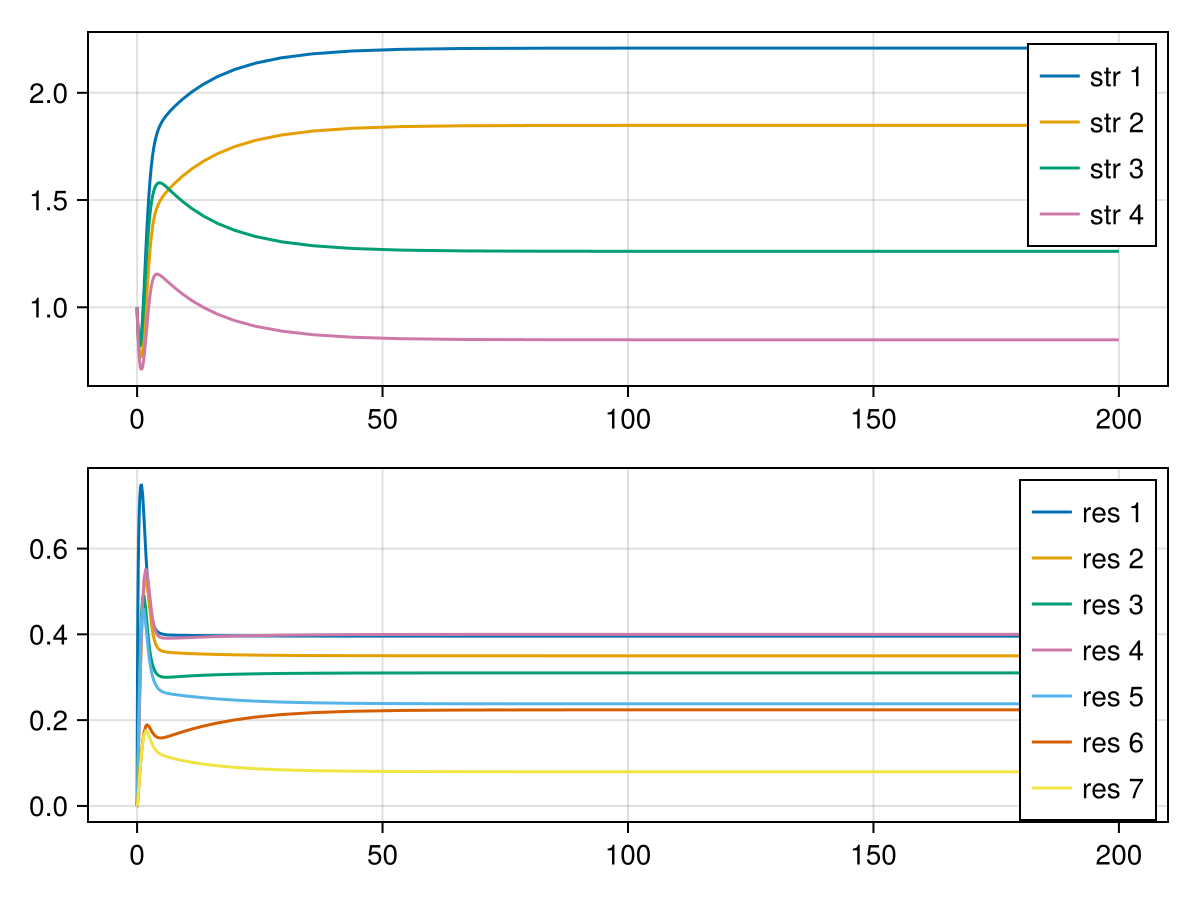

11-element Vector{Float64}:
 2.2083698366382762
 1.8481259347079133
 1.260843689623152
 0.8482064385762076
 0.3958485996019843
 0.3500000044167428
 0.31020497783099676
 0.3999999912804951
 0.23798620224184044
 0.22402758271570503
 0.07959005177302415

In [459]:
l = fill(0., 4, 7)
c = fill(0., 4, 7)
c[:, 1] .= 2. # they all eat glucose
l[:, 1] .= 1. # and they leak all of it

D = fill(0., 4, 7, 7)
# 1-2 cross feeding
D[1, 2, 1] = 0.8
c[2, 2] = 2.
D[2, 3, 1] = 1.
c[1, 3] = 2.

# 3-4 cross feeding
D[3, 4, 1] = 0.8
c[4, 4] = 2.
D[4, 5, 1] = 1.
c[3, 5] = 2.

# 1-3 cross feeding
D[1, 6, 1] = 0.2
c[3, 6] = 1.
D[3, 7, 1] = 0.2
c[1, 7] = 1.

# display(l)
# display(c)
# display(D)
p = make_mmicrm_smart(4, 7, 200;
    D, l, c,
    K=[5., 0., 0., 0., 0., 0., 0.],
    r=fill(0.3, 7),
    m=[0.7, 0.7, 0.7, 0.8],
    u0=:onlyN,
    u0rand=0.
)
s = solve(p)
display(plot_mmicrm_sol(s))
s[end]
#param_summary(p.p)
# check_mmicrmparams(p.p)

#### Steady state solving

In [441]:
symsol = symbolic_solve_ode_ml(p)

┌ Warning: Solve::ratnz: Solve was unable to solve the system with inexact coefficients.
│     The answer was obtained by solving a corresponding exact system and
│     numericizing the result.
└ @ MathLink ~/.julia/packages/MathLink/S39uA/src/eval.jl:16


68-element Vector{Vector{Pair{Symbolics.Num, Complex{Symbolics.Num}}}}:
 [u1 => -0.0025988975085542093, u2 => 0.023669403378296625, u3 => -0.25658264915542583, u4 => 0.0, u5 => -29.235613843145874, u6 => 0.35, u7 => -4.694602179828955, u8 => 40.00720666431685, u9 => 0.0, u10 => 0.7, u11 => 10.08920435965791]
 [u1 => -0.268803788844196, u2 => 0.0, u3 => -0.0021008814332768105, u4 => 0.02469878247250254, u5 => -25.9859355496831, u6 => 37.25396230621814, u7 => 0.0, u8 => 0.25, u9 => -4.339586169991557, u10 => 9.379172339983114, u11 => 0.7]
 [u1 => -0.15, u2 => 0.0, u3 => -0.15, u4 => 0.0, u5 => -16.666666666666668, u6 => 13.333333333333334, u7 => -2.9833333333333334, u8 => 13.333333333333334, u9 => -2.9833333333333334, u10 => 6.666666666666667, u11 => 6.666666666666667]
 [u1 => 0.0, u2 => 0.0, u3 => -0.3, u4 => 0.0, u5 => -16.666666666666668, u6 => 0.0, u7 => 0.0, u8 => 26.666666666666668, u9 => 0.0, u10 => 0.7, u11 => 6.666666666666667]
 [u1 => 0.0, u2 => -0.15, u3 => -0.15, u4 => 0.0, u

In [442]:
sssol = solve(SteadyStateProblem(p), DynamicSS())
show(sssol)

[0.7848085563651047, 0.45823748270012793, 2.9400914317494093, 3.0400370685680427, 0.33906697828798793, 0.3499982392867059, 0.16620874354057866, 0.2500003395867015, 0.33357465187743274, 0.032851282532246937, 0.36758037265435534]

## Linear stability analysis

In [443]:
ks = LinRange(0., 20., 1000)
Ds = [fill(1e-4, 4); 0; fill(1, 4); fill(10, 2)]
usol = s.u[end]
#usol = sssol.u
#usol = Symbolics.value.(getindex.(symsol[2], 2))
show(uninplace(mmicrmfunc!)(usol, p.p, 0))

[-6.759986825180546e-8, -6.494945598110158e-8, 6.939756429766207e-8, 8.312609335649399e-8, -9.250307186903228e-10, 6.788483775110876e-9, -1.2618562084121265e-8, -1.3157293032861617e-9, 7.332676688065476e-10, -3.7363708793591854e-9, 3.3503272212076496e-8]

maximum(real(lambdas)) = 0.034276484629723526


[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.943109
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.943109
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.916713
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.204643
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.033348
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.033348


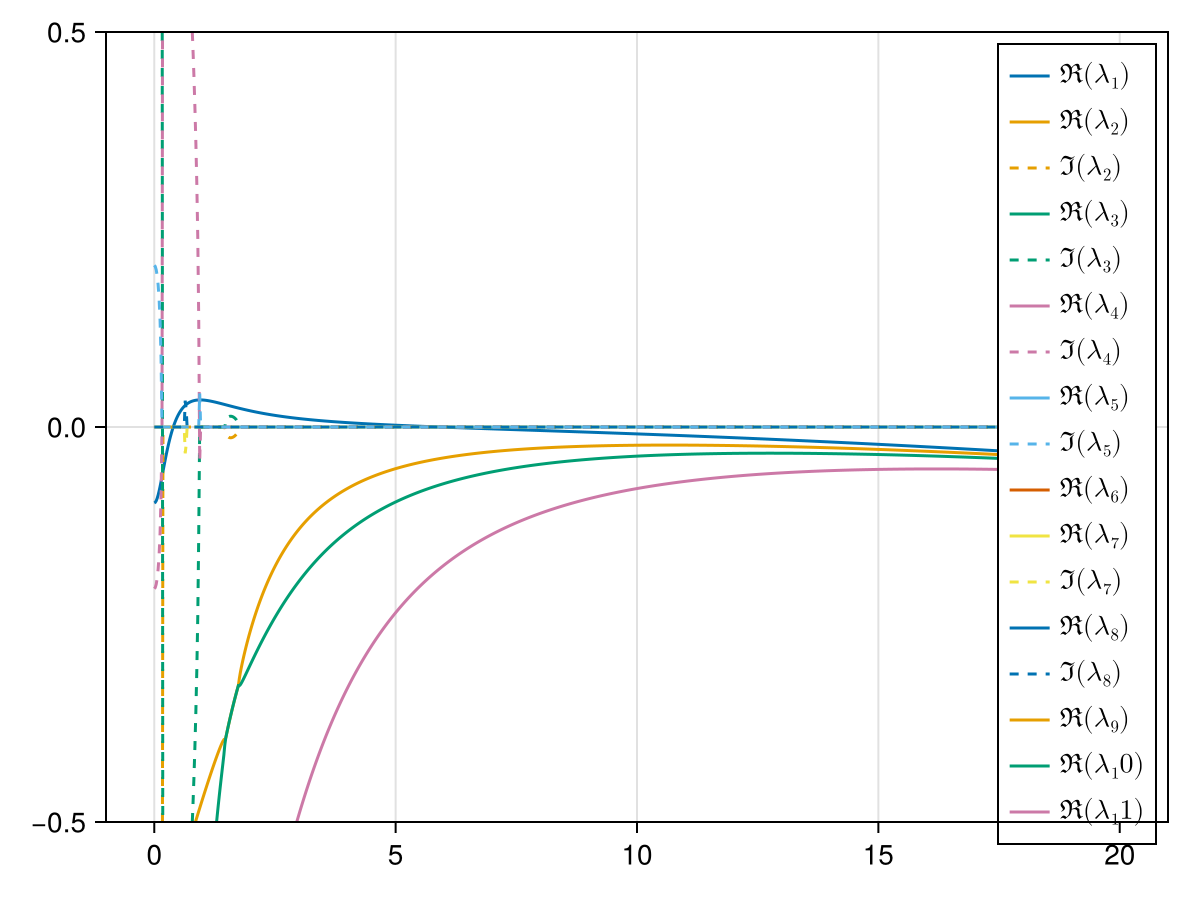

In [444]:
lambdas = do_linstab_for_ks(ks, p, Ds, usol);
@show maximum(real(lambdas))
faa = plot_linstab_lambdas(ks, lambdas[:,:])
ylims!(faa.axis, (-0.5, 0.5))
#xlims!(faa.axis, (0., 2.))
faa

In [445]:
# Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax

(49, 0.960960960960961)

In [446]:
ff = linstab_make_full_func(p.p, usol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

11-element Vector{Float64}:
 -0.6090453874832185
 -0.41725119165119456
  0.46034391801859753
  0.49106688888810296
  0.003435748813348344
 -0.01564799814882835
 -0.027358137726897082
  0.0027758322893901683
  0.006553762904345091
 -0.007726272080549818
  0.028043940217003

## Spatial stuff - 1D!

In [460]:
ssize = (600,)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 1.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.04, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 100000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((11, 600), 18, CartesianSpace{1, Tuple{Periodic}, Float64}([0.04]))

#### Direct solver

 10.528047 seconds (986.26 k allocations: 2.555 GiB, 19.38% gc time)


ReturnCode.Success = 1

6952

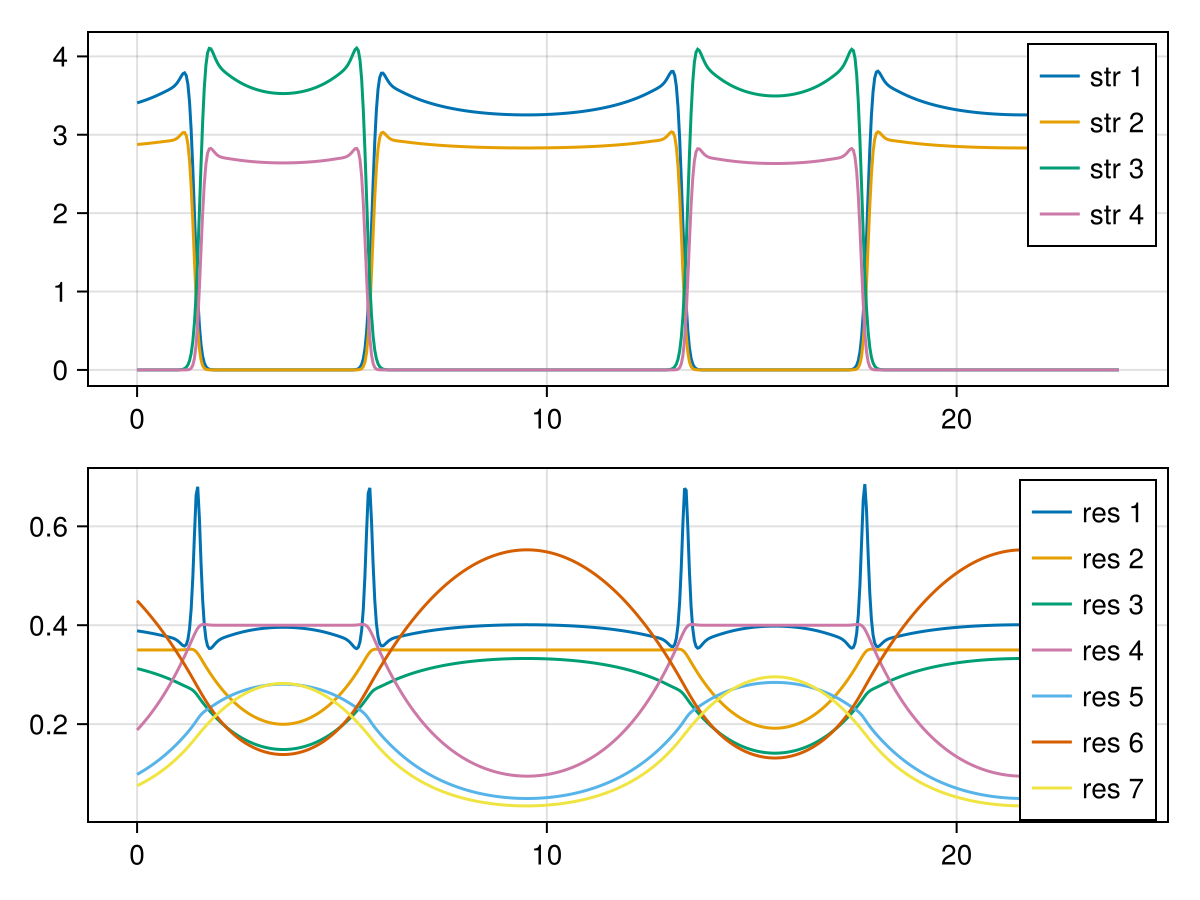

In [461]:
@time sps = solve(sp, QNDF(); maxiters=1000)
display(sps.retcode)
display(sps.destats.nf)
#display(plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end-1]))
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

#### Steady state solver

 12.204321 seconds (836.84 k allocations: 2.199 GiB, 1.90% gc time)


ReturnCode.Success = 1

2803

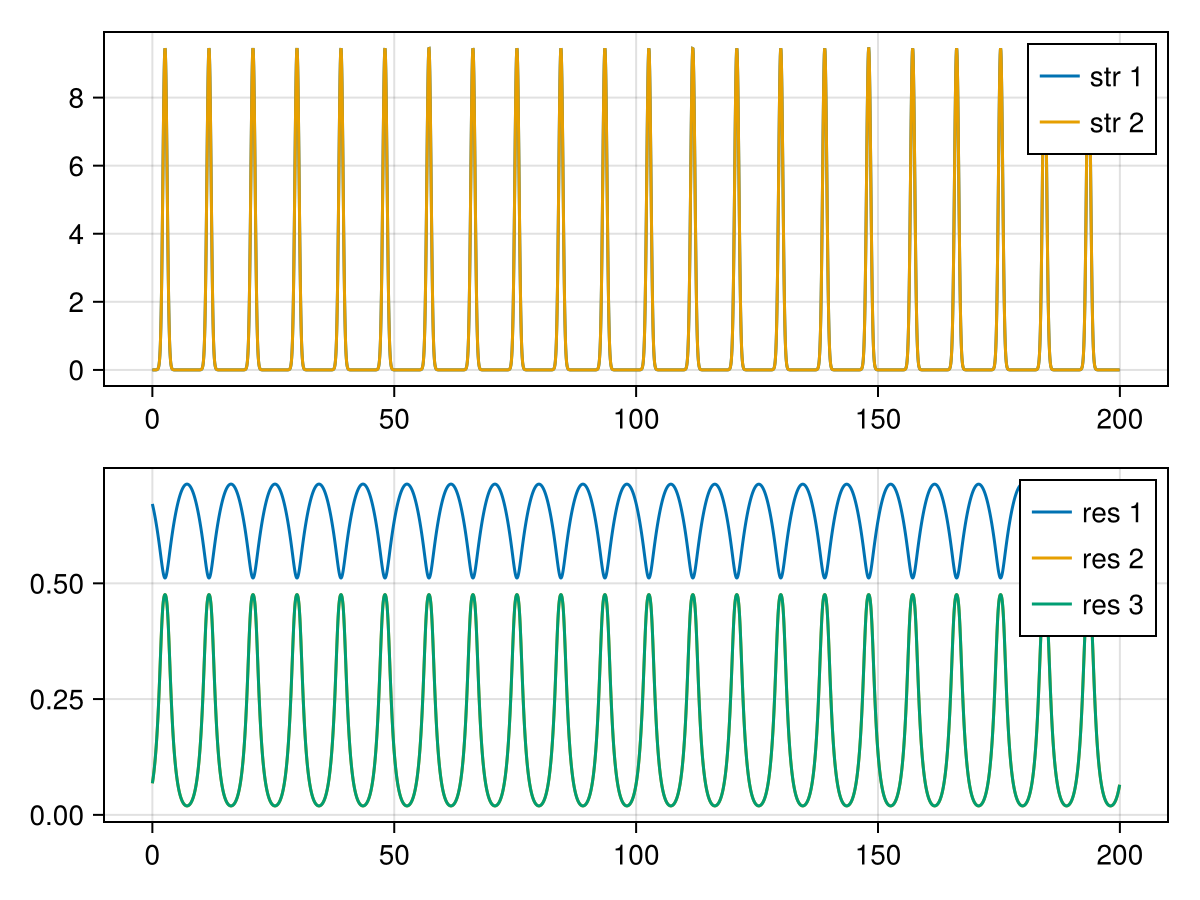

In [87]:
sssp = SteadyStateProblem(sp)
@time sssps = solve(sssp, DynamicSS(QNDF()); maxiters=1000)
display(sssps.retcode)
display(sssps.original.destats.nf)
plot_1dsmmicrm_sol_snap(sssps.prob.p, sssps.u)

## Spatial stuff - 2D!

In [462]:
ssize = (70,70)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 1e-6)
space = make_cartesianspace_smart(length(ssize); dx=0.2, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 1000000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((11, 70, 70), 18, CartesianSpace{2, Tuple{Periodic, Periodic}, Float64}([0.2, 0.2]))

#### Direct solver

In [463]:
@time sps = solve(sp, TRBDF2(); maxiters=1000)
if sps.retcode != ReturnCode.Success
    display(sps.retcode)
end
display(sps.destats.nf)
@show length(sps.u)
maximum(abs, uninplace(sps.prob.f)(sps.u[end], sps.prob.p))

1047.609039 seconds (1.97 M allocations: 146.997 GiB, 3.81% gc time)


6363

length(sps.u) = 439


1.0019540752637113e-11

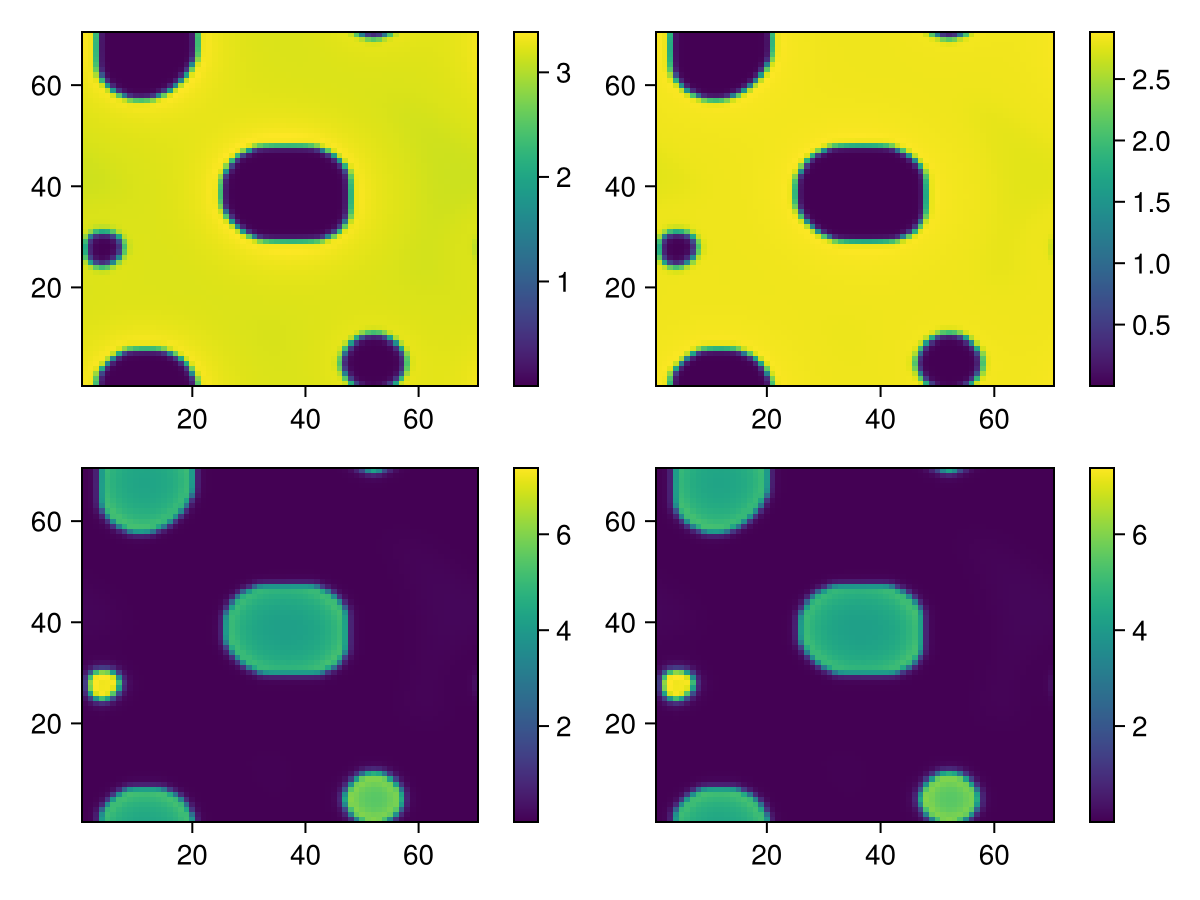

In [507]:
xx = sps.u[end]
plot_heatmaps([xx[1,:,:], xx[2,:,:], xx[3,:,:], xx[3,:,:]])

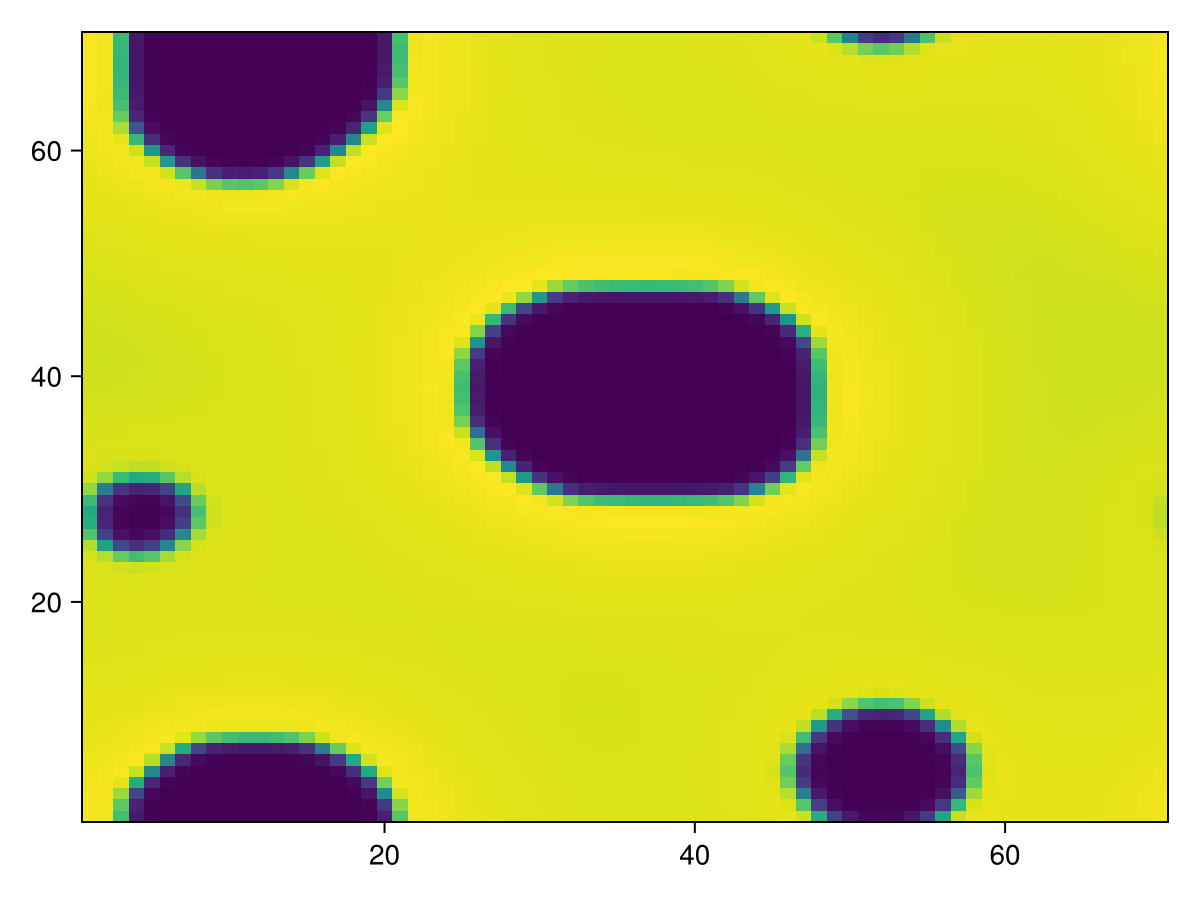

In [490]:
heatmap(sps(sps.t[end])[1,:,:])

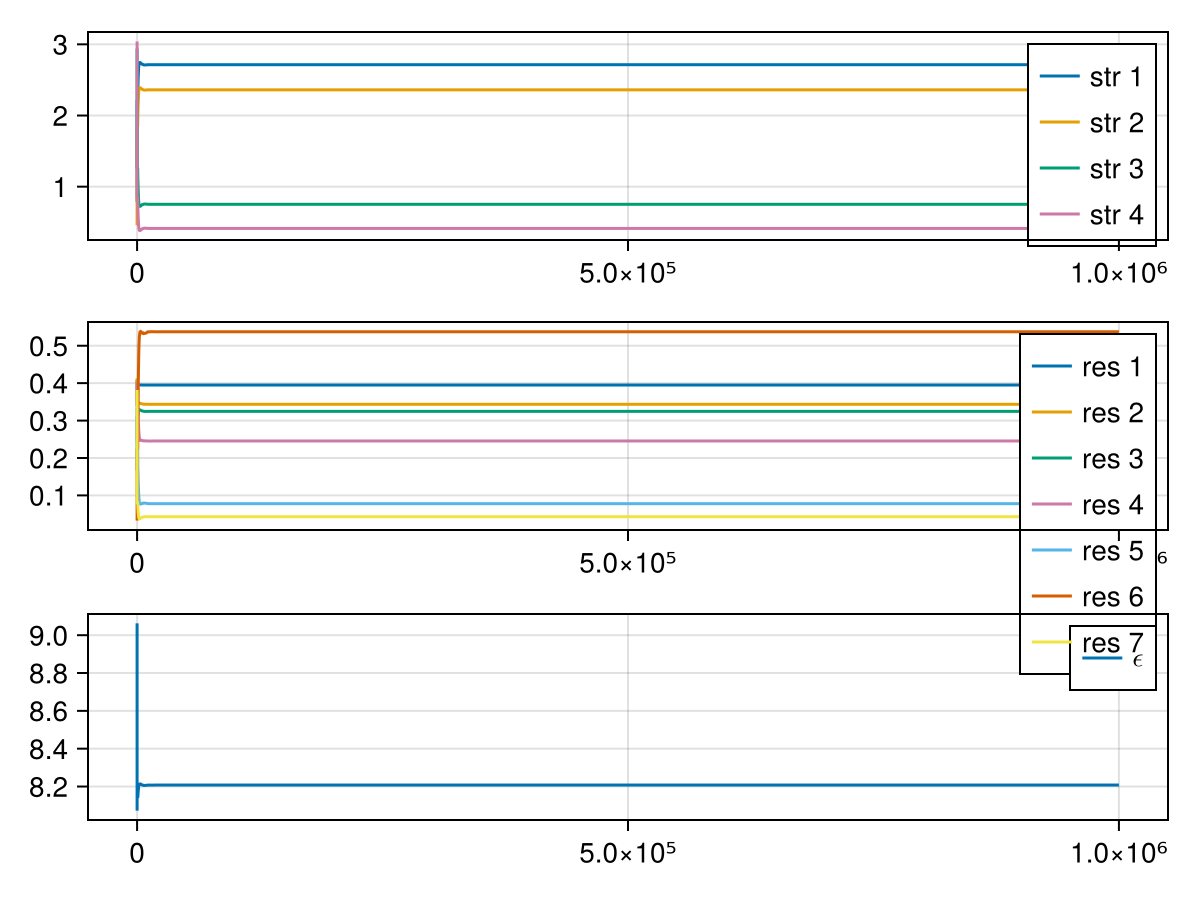

In [467]:
plot_smmicrm_sol_avgs(sps; plote=true)

In [466]:
sps.stats

SciMLBase.DEStats
Number of function 1 evaluations:                  6363
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    280
Number of linear solves:                           4976
Number of Jacobians created:                       57
Number of nonlinear solver iterations:             3984
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          438
Number of rejected steps:                          59

#### Loading/saving solutions

In [468]:
save_object(datadir("layers47", randname()*".jld2"), sps)

In [418]:
sps = load_object("../data/layers47/sl2d_2_no_g_D.jld2");
#sps = load_object("../data/layers47/sl2d_1.jld2");
@show length(sps.u)
@printf "max abs(du) is %g" maximum(abs, uninplace(sps.prob.f)(sps.u[end], sps.prob.p))

length(sps.u) = 566
max abs(du) is 4.38372e-13

#### Extra time

In [91]:
ftime = sps.prob.tspan[end]
esp = remake(sps.prob; u0=sps.u[end], tspan=(ftime, 2*ftime));
size(esp.u0), esp.p.usenthreads, esp.p.space

((11, 80, 80), 18, CartesianSpace{2, Tuple{Periodic, Periodic}, Float64}([0.1, 0.1]))

In [92]:
@time sps = solve(esp, TRBDF2(); maxiters=1000)
display(sps.retcode)
display(sps.destats.nf)

 85.280936 seconds (1.28 M allocations: 13.719 GiB, 5.73% gc time)


ReturnCode.Success = 1

103

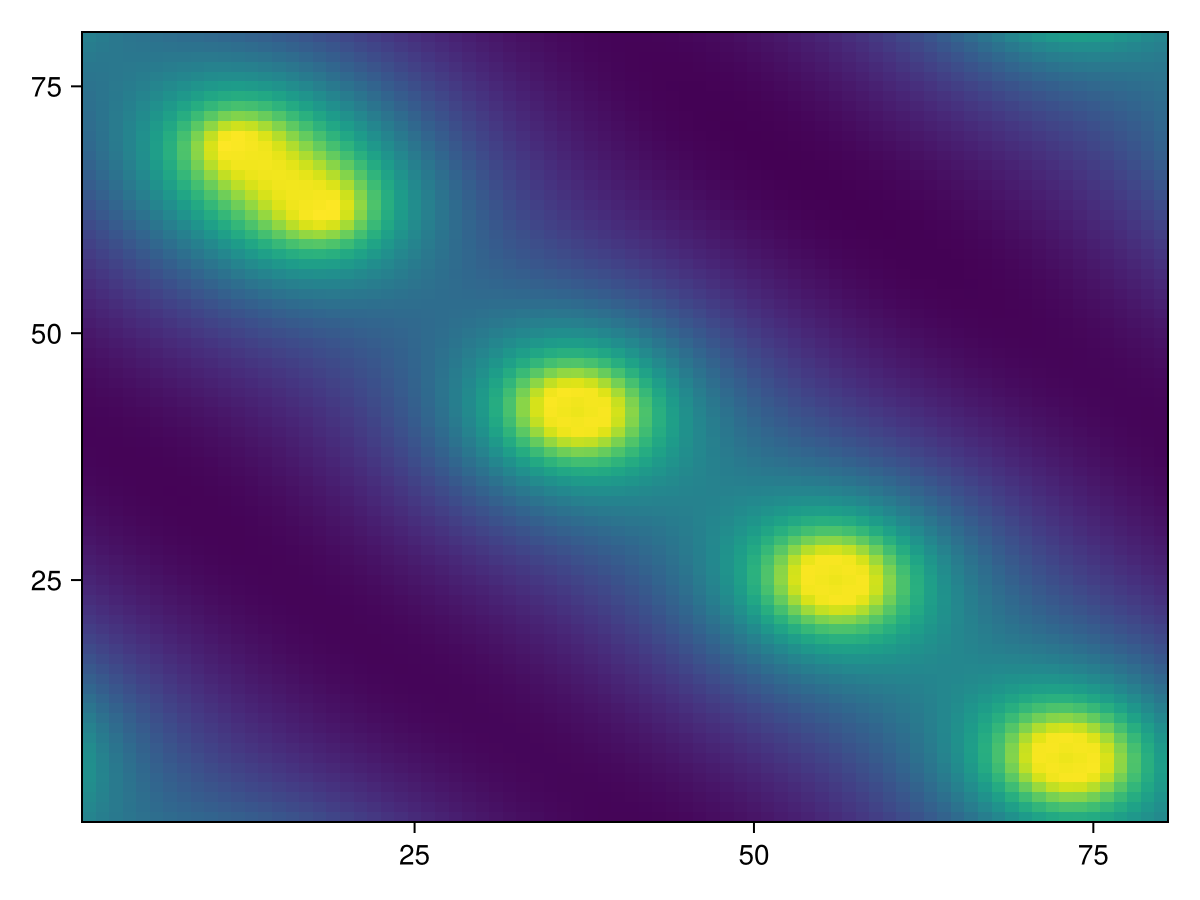

In [93]:
heatmap(sps.u[end][8,:,:])

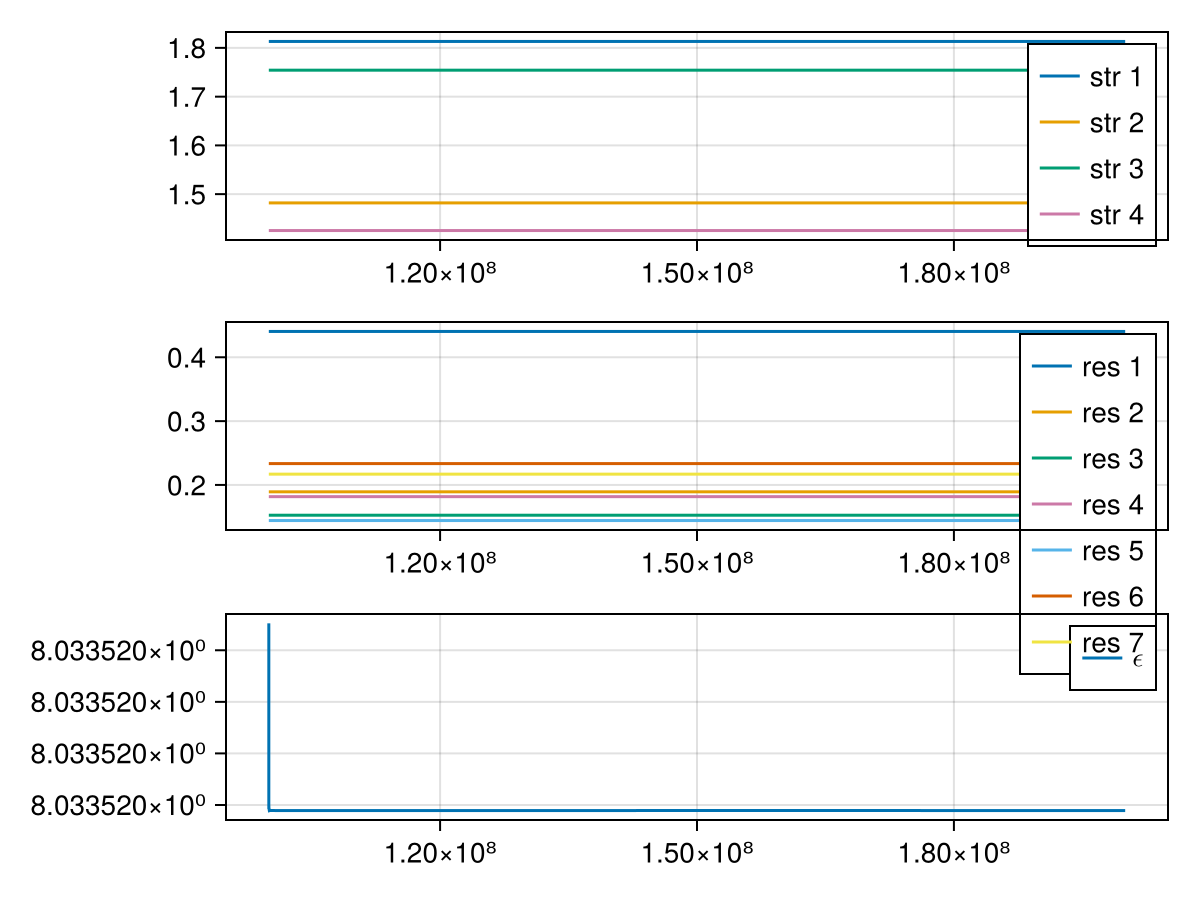

In [95]:
plot_smmicrm_sol_avgs(sps; plote=true)

# Extras

In [263]:
GC.gc()
empty!(Out)

Dict{Int64, Any}()